In [1]:
!mkdir -p-/.kaggle
!kaggle datasets download -d xying0613/pictures-of-animals-for-image-classification

mkdir: invalid option -- '-'
Try 'mkdir --help' for more information.
Dataset URL: https://www.kaggle.com/datasets/xying0613/pictures-of-animals-for-image-classification
License(s): unknown
pictures-of-animals-for-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import zipfile
zip_ref = zipfile.ZipFile("/content/pictures-of-animals-for-image-classification.zip", 'r')
zip_ref.extractall("/content")

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import  preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense,Dropout
from tensorflow.keras.applications import VGG16

In [4]:
# Load and preprocess data
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/Animals",
    seed=123,
    image_size=(224, 224),
    batch_size=1  # or your desired batch size
)

x, y = zip(*train_ds)  #changed from 1 to 64
x = tf.concat(x, axis=0)
y = tf.concat(y, axis=0)

# Get the class names from the dataset
class_names = train_ds.class_names

# Find the index corresponding to 'cats'
cat_index = class_names.index('cats')

# Create binary labels using the cat_index
y_binary = np.where(y == cat_index, 1, 0)

# Split data into training, validation, and testing sets
training_ratio = 0.7
val_ratio = 0.15  # 15% for validation
test_ratio = 0.15  # 15% for testing

num_samples = len(x)
x_train, x_val, x_test = x[:int(training_ratio * num_samples)], x[int(training_ratio * num_samples):int((training_ratio + val_ratio) * num_samples)], x[int((training_ratio + val_ratio) * num_samples):]
y_train, y_val, y_test = y_binary[:int(training_ratio * num_samples)], y_binary[int(training_ratio * num_samples):int((training_ratio + val_ratio) * num_samples)], y_binary[int((training_ratio + val_ratio) * num_samples):]


# Preprocess images
x_train_preprocessed = preprocess_input(x_train)
x_test_preprocessed = preprocess_input(x_test)
x_val_preprocessed = preprocess_input(x_val)

base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),include_top=False,weights='imagenet')
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))


model.summary()

Found 5002 files belonging to 10 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      16,056,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,381,380 (70.12 MB)

 Trainable params: 16,123,396 (61.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# Compile the model

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    x_train_preprocessed,
    y_train,
    validation_data=(x_val_preprocessed, y_val),
    batch_size=64,
    epochs=10
)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 414ms/step - accuracy: 0.8696 - loss: 1.9915 - val_accuracy: 0.9973 - val_loss: 0.0293
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.9894 - loss: 0.2824 - val_accuracy: 0.9987 - val_loss: 0.0184
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9947 - loss: 0.1763 - val_accuracy: 1.0000 - val_loss: 2.1656e-04
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9967 - loss: 0.0519 - val_accuracy: 0.9973 - val_loss: 0.0068
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9963 - loss: 0.1034 - val_accuracy: 0.9973 - val_loss: 0.0550
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.9975 - loss: 0.0482 - val_accuracy: 0.9987 - val_loss: 0.0138
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9951 - loss: 0.1565 - val_accuracy: 1.0000 - val_loss: 4.8668e-06
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9950 - loss: 0.0565 - val_accuracy:

In [6]:
Y_pred = model.predict(x_test_preprocessed)
print(y_test[:10])
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, Y_pred.argmax(axis=1))
print("Accuracy:", accuracy)

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step
[0 0 0 0 0 0 0 0 0 0]
Accuracy: 0.9933422103861518


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score


Y_pred = model.predict(x_test_preprocessed)
y_pred_classes = Y_pred.argmax(axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Precision: 0.9848484848484849
Recall: 0.9420289855072463
F1-score: 0.9629629629629629


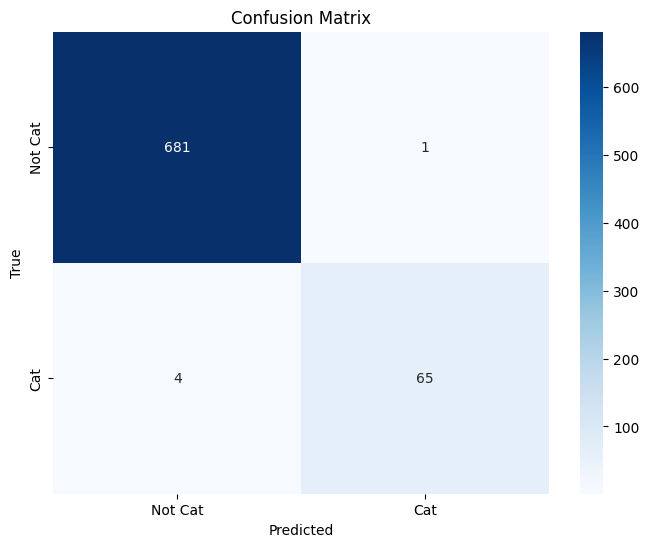

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_classes are defined from the previous code

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Cat', 'Cat'], yticklabels=['Not Cat', 'Cat'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Confusion Matrix:
 [[681   1]
 [  4  65]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       682
           1       0.98      0.94      0.96        69

    accuracy                           0.99       751
   macro avg       0.99      0.97      0.98       751
weighted avg       0.99      0.99      0.99       751



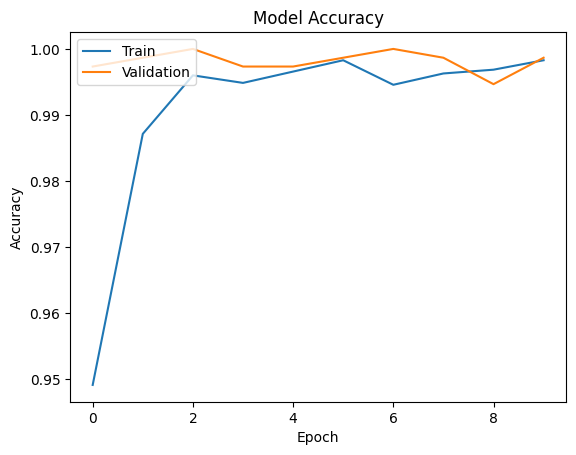

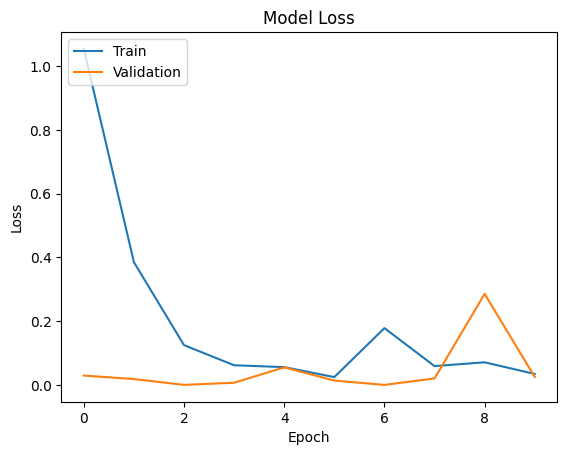

In [9]:
from sklearn.metrics import classification_report
cm = confusion_matrix(y_test, y_pred_classes)  # Use y_pred_classes instead of predicted_classes
print("Confusion Matrix:\n", cm)

cr = classification_report(y_test, y_pred_classes)  # Use y_pred_classes instead of predicted_classes
print("Classification Report:\n", cr)

# Step 12: Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()